In [1]:
%matplotlib notebook
import numpy as np
import glob, os
import g0_init_cfg as ic
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from astropy.io import fits

# ----- Importing IRAF from the root directory ----- #
current_dir = os.getcwd()
os.chdir(ic.dir_iraf)

from pyraf import iraf
from pyraf.iraf import gemini, gmos

os.chdir(current_dir)
iraf.chdir(current_dir)

uparm parameter list `/data01/jhlee/anaconda3/envs/iraf27/iraf/noao/imred/ccdred/ccdtest/ccdtest.par' inconsistent with default parameters for IrafPkg `ccdtest'


In [2]:
# Find the gaps
flat = np.loadtxt(ic.lst_flat, dtype=str)
if (flat.size > 1):
    raise ValueError("Please check if there is only one flat image for the standard star.")
flat0 = flat.item(0)

iraf.sections('blkmask_@'+ic.lst_flat, Stdout='blkmask.lis')
iraf.delete('@blkmask.lis', verify='no')
iraf.delete('blkmask.lis', verify='no')

iraf.gffindblocks('rg'+flat0, 'erg'+flat0, 'blkmask_'+flat0)

1 512 100 104
1 512 374 380
1 512 648 653
1 512 921 928
1 512 1195 1201
1 512 1468 1476
1 512 1743 1747
1 512 2014 2019
1 512 2286 2292
1 512 2553 2562
1 512 2829 2838
1 512 3105 3110
1 512 3378 3384
1 512 3652 3657
1 512 3924 3932
1 512 4175 4176
16 gaps found


In [3]:
# Reading FITS images
flat_name = 'rg'+flat0+'.fits'
fits.open(flat_name).info()

hdr_num = 1
rg = fits.getdata(flat_name, ext=hdr_num)
np.shape(rg)

Filename: rgS20230225S0053.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     395   ()      
  1  SCI           1 ImageHDU        71   (512, 4176)   float32   
  2  SCI           2 ImageHDU        71   (512, 4176)   float32   
  3  SCI           3 ImageHDU        71   (512, 4176)   float32   
  4  SCI           4 ImageHDU        71   (512, 4176)   float32   
  5  SCI           5 ImageHDU        71   (512, 4176)   float32   
  6  SCI           6 ImageHDU        71   (512, 4176)   float32   
  7  SCI           7 ImageHDU        71   (512, 4176)   float32   
  8  SCI           8 ImageHDU        71   (512, 4176)   float32   
  9  SCI           9 ImageHDU        71   (512, 4176)   float32   
 10  SCI          10 ImageHDU        71   (512, 4176)   float32   
 11  SCI          11 ImageHDU        71   (512, 4176)   float32   
 12  SCI          12 ImageHDU        71   (512, 4176)   float32   
 13  MDF           1 BinTableHDU     37   750R x 7C

(4176, 512)

In [4]:
# Reading blkmask file made by IRAF/Gemini package
msk_ascii = np.genfromtxt('blkmask_'+flat0, dtype=int)
print(msk_ascii)

# Mask flagging (int_msk : from IRAF/Gemini)
int_msk = rg*0

for i in np.arange(msk_ascii.shape[0]):
    reg = (msk_ascii[i]-1).tolist()
    int_msk[reg[2]-1:reg[3], :] = 1

bin_msk = (int_msk == 1)

[[   1  512  100  104]
 [   1  512  374  380]
 [   1  512  648  653]
 [   1  512  921  928]
 [   1  512 1195 1201]
 [   1  512 1468 1476]
 [   1  512 1743 1747]
 [   1  512 2014 2019]
 [   1  512 2286 2292]
 [   1  512 2553 2562]
 [   1  512 2829 2838]
 [   1  512 3105 3110]
 [   1  512 3378 3384]
 [   1  512 3652 3657]
 [   1  512 3924 3932]
 [   1  512 4175 4176]]


<IPython.core.display.Javascript object>


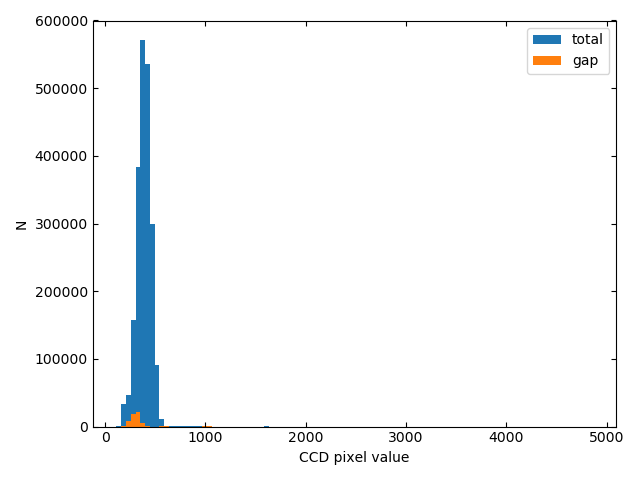

In [5]:
fig, ax = plt.subplots()
n1, bins1, x1 = ax.hist(rg.flatten(), bins=100, color='C0', label='total')
n2, bins2, x2 = ax.hist(rg[bin_msk].flatten(), bins=bins1, color='C1', label='gap')
ax.set_xlabel("CCD pixel value")
ax.set_ylabel("N")
plt.legend()
plt.tight_layout()

In [6]:
gap_upper_limit = 8000  # by zoom-in of the above histogram

<IPython.core.display.Javascript object>


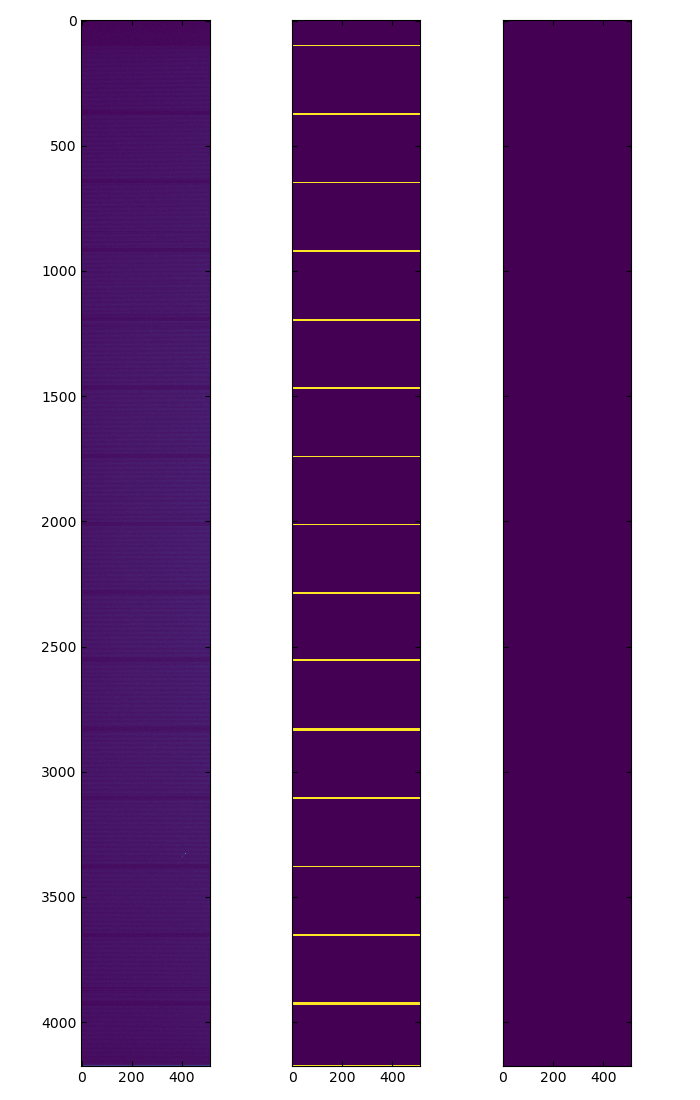

In [7]:
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(7,11))
ax[0].imshow(rg, origin='upper')  # flat data
ax[1].imshow(int_msk, origin='upper')  # displaying gap
ax[2].imshow((bin_msk & (rg > gap_upper_limit)), origin='upper')  # check the gap upper limit
plt.tight_layout()

<IPython.core.display.Javascript object>


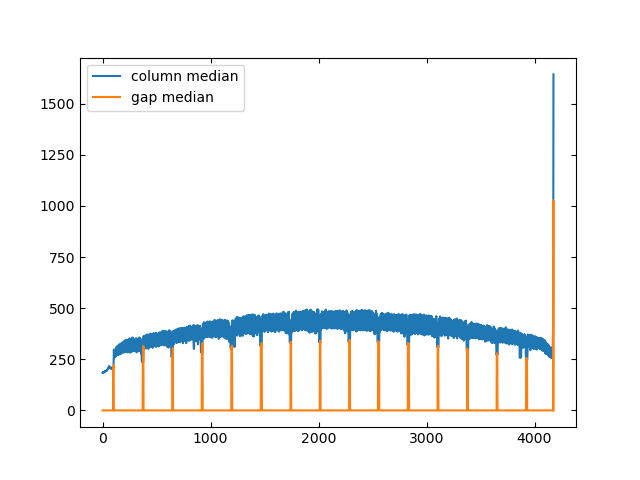

In [8]:
fig, ax = plt.subplots()
ax.plot(np.median(rg, axis=1), label='column median')
ax.plot(np.median(int_msk*rg, axis=1), zorder=+10, label='gap median')
plt.legend()

In [9]:
all_gaps_are_ok = False  # If False, new gap mask file should be written below.

if all_gaps_are_ok:
    blkmsk_name = 'blkmask_'+flat0
else:
    blkmsk_name = 'newblkmask_'+flat0+'_hdr{0:02d}'.format(hdr_num)

with open("blkmask_name.txt", "w") as f:
    f.write(blkmsk_name+"\n")

If ``all_gap_are_ok`` is ``False``, you have to check the gap manually with the following process below.

<IPython.core.display.Javascript object>


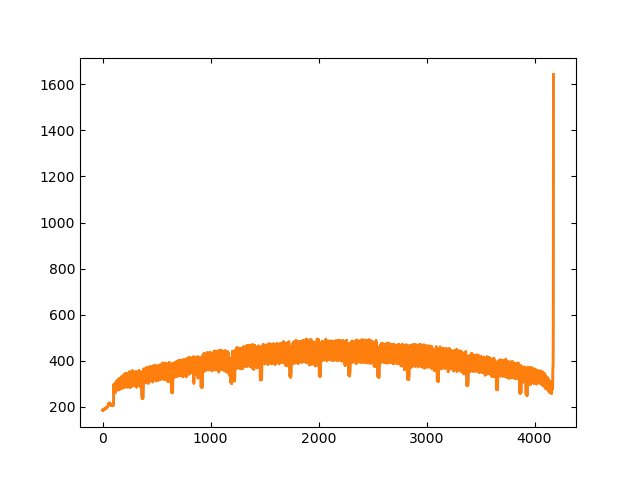

In [10]:
fig, ax = plt.subplots()
column_median = np.median(rg, axis=1)
ax.plot(column_median, label='column median')

gaps = (column_median < gap_upper_limit)
jmsk = np.zeros_like(column_median)
jmsk[~gaps] = np.nan
jmsk[gaps] = column_median[gaps]
# jmsk[:100] = np.nan  # masking the edge region
ax.plot(jmsk, linewidth=2.0, zorder=+10)

In [11]:
gap_width = 270
idx_jmsk = np.arange(len(jmsk))[np.isnan(jmsk) == False]
print(idx_jmsk)
div_jmsk = idx_jmsk / gap_width
print(idx_jmsk / gap_width)

[   0    1    2 ... 4173 4174 4175]
[ 0  0  0 ... 15 15 15]


In [12]:
gap_half = 2

idx = idx_jmsk[div_jmsk == 0]
idx_min = idx[jmsk[idx] == np.min(jmsk[idx])]
# idx_min = idx[jmsk[idx] == np.min(jmsk[idx])]
idx_gap = np.zeros((len(np.unique(div_jmsk)), 2))

for i in np.unique(div_jmsk):
    idx = idx_jmsk[div_jmsk == i]
    idx_min = idx[jmsk[idx] == np.min(jmsk[idx])]
    jmsk[idx] = np.nan
    if (int(idx_min-gap_half) < 0):
        idx_gap = np.zeros((len(np.unique(div_jmsk))-1, 2))
        ii = 0
        continue
    jmsk[int(idx_min-gap_half):int(idx_min+gap_half+1)] = column_median[int(idx_min-gap_half):int(idx_min+gap_half+1)]
    print(int(idx_min-gap_half), int(idx_min+gap_half))
    idx_gap[ii] = (int(idx_min-gap_half), int(idx_min+gap_half))
    ii += 1

(368, 372)
(646, 650)
(920, 924)
(1193, 1197)
(1460, 1464)
(1741, 1745)
(2009, 2013)
(2286, 2290)
(2557, 2561)
(2833, 2837)
(3106, 3110)
(3377, 3381)
(3655, 3659)
(3929, 3933)
(4156, 4160)


<IPython.core.display.Javascript object>


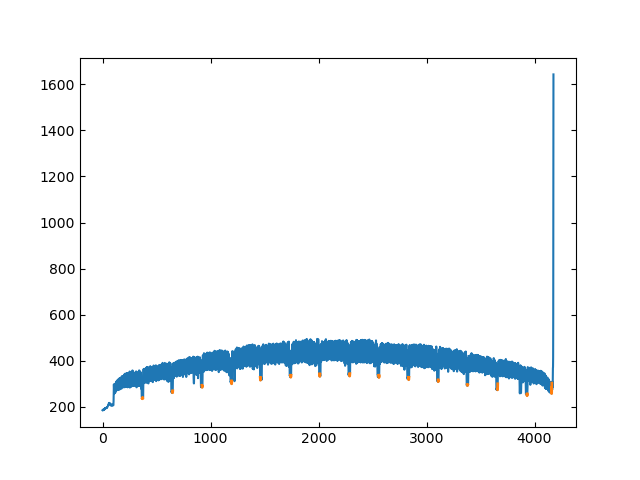

In [13]:
fig, ax = plt.subplots()
ax.plot(column_median)
ax.plot(jmsk, linewidth=2.0, zorder=+10)

In [14]:
msk_jh = np.zeros((idx_gap.shape[0], msk_ascii.shape[1]))
for i in np.arange(np.shape(msk_jh)[0]):
    msk_jh[i] = np.array([1, np.shape(rg)[1], int(idx_gap[i,0]), int(idx_gap[i,1])])
msk_jh = msk_jh.astype('int')
print(msk_jh)

[[   1  512  368  372]
 [   1  512  646  650]
 [   1  512  920  924]
 [   1  512 1193 1197]
 [   1  512 1460 1464]
 [   1  512 1741 1745]
 [   1  512 2009 2013]
 [   1  512 2286 2290]
 [   1  512 2557 2561]
 [   1  512 2833 2837]
 [   1  512 3106 3110]
 [   1  512 3377 3381]
 [   1  512 3655 3659]
 [   1  512 3929 3933]
 [   1  512 4156 4160]]


In [15]:
if (all_gaps_are_ok == False):
    f = open(blkmsk_name, 'w')
    for i in np.arange(np.shape(msk_jh)[0]):
        f.write(str(msk_jh[i,0])+' '+str(msk_jh[i,1])+' '+str(msk_jh[i,2])+' '+str(msk_jh[i,3])+'\n')
    f.close()